In [1]:
import librosa.display
import librosa.util
from IPython.display import Audio
import os
import scipy
from scipy.io import wavfile
import numpy as np
import utils.synthesis_util as su
import utils.model_util as mu
from utils.metrics import Metrics
from pesq_lib.pypesq import pypesq

## Examine dataset

In [2]:
audio_files = su.load_files()
id_audio=10010

### Clean audio

In [3]:
y_clean, sr = su.get_audio(audio_id=id_audio,audio_files=audio_files)
Audio(y_clean,rate=sr)

## Noisy audio

In [4]:
y_noise, sr, noise = su.get_noisy_audio(audio_id=id_audio,audio_files=audio_files, noise_factor=0.05)
Audio(y_noise,rate=sr)

In [5]:
win = scipy.signal.hamming(256,"periodic")
magnitude,phase = su.audio_to_sttft(y_noise,win)

In [6]:
predictors = su.get_predictors(magnitude, type="rnn")

In [7]:
predictors = np.array(predictors)
predictors.shape

(336, 129)

## Load module

In [8]:
model = mu.load_model(n_features=129,n_segments=8,model_to_test="./saved/LSTM/0603_164023", type='lstm')

## Denoise

In [9]:
length = len(y_noise)

In [10]:
sample = su.obtain_sample(predictors)

In [11]:
audio_rec = su.denoise_audio(model,sample,phase,win,length, type ='rnn')
Audio(audio_rec,rate=sr)

In [12]:
type(sample)

torch.Tensor

### Visualize spectrograms

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np

/home/colm/anaconda3/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


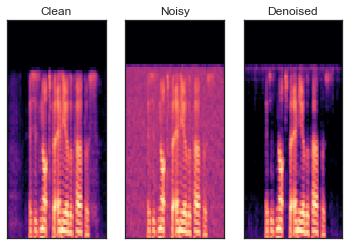

In [14]:
plt.subplot(1,3,1)
S = librosa.feature.melspectrogram(y=y_clean,
                                   sr=sr,
                                   n_fft=1024,
                                   hop_length=256,
                                   n_mels=80,
                                   fmin=125,
                                   fmax=7600)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
plt.title("Clean")

plt.subplot(1,3,2)
S = librosa.feature.melspectrogram(y=y_noise,
                                   sr=sr,
                                   n_fft=1024,
                                   hop_length=256,
                                   n_mels=80,
                                   fmin=125,
                                   fmax=7600)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
plt.title("Noisy")

plt.subplot(1,3,3)
S = librosa.feature.melspectrogram(y=audio_rec,
                                   sr=sr,
                                   n_fft=1024,
                                   hop_length=256,
                                   n_mels=80,
                                   fmin=125,
                                   fmax=7600)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
plt.title("Denoised")
plt.show()


# Calculate metrics

In [15]:
magnitude_clean,phase_clean = su.audio_to_sttft(y_clean,win)
magnitude_noise,phase_noise = su.audio_to_sttft(y_noise,win)
magnitude_denoised,phase_denoised = su.audio_to_sttft(audio_rec,win)
print(f"SNR_db for clean: {10*np.log10(Metrics.DER_SNR(Metrics.spectral_flux(magnitude_clean, sr)))}")
print(f"SNR_db for noise: {10*np.log10(Metrics.DER_SNR(Metrics.spectral_flux(magnitude_noise, sr)))}")
print(f"SNR_db for denoised: {10*np.log10(Metrics.DER_SNR(Metrics.spectral_flux(magnitude_denoised, sr)))}")


SNR_db for clean: 29.165345224089464
SNR_db for noise: 31.620727802428878
SNR_db for denoised: 28.357189202259168


In [16]:
print(sr)

8000.0


In [21]:
print(f"PESQ value with narrowband (nb) considering original signal and original+noise: {pypesq(sr, y_clean, y_noise, 'nb')}")
print(f"PESQ value with narrowband (nb) considering original signal and reconstructed signal: {pypesq(sr, y_clean, audio_rec, 'nb')}")

PESQ value with narrowband (nb) considering original signal and original+noise: 4.548638343811035
PESQ value with narrowband (nb) considering original signal and reconstructed signal: 2.938549280166626


### Aggregated metrics

In [18]:
trainset_indices = su.get_trainset_indices()
print(trainset_indices)
testset_inidices = su.get_testset_indices()
print(testset_inidices)

[69, 7334, 4207, 7011, 6034, 5094, 2414, 6472, 4265, 6315]
[8235, 8245, 8228, 8226, 8247, 8196, 8234, 8223, 8247, 8247]


In [19]:
Metrics.aggregate_metric_check(audio_files, model, indices=trainset_indices, type="rnn")

Computing... 0.0%


{'pesq': {'clean': (4.548638343811035, 0.0),
  'denoised': (2.6892776250839234, 0.5048076275336154),
  'noise': (2.2804357171058656, 0.733559072212998)},
 'snr': {'clean': (33.791126112754554, 3.86260869143447),
  'denoised': (33.35474776021938, 4.029982861526765),
  'noise': (33.95213896893762, 2.648395111763802)}}

In [23]:
Metrics.aggregate_metric_check(audio_files, model, indices=testset_inidices, type="rnn")

Computing... 0.0%


{'pesq': {'clean': (4.548638343811035, 0.0),
  'denoised': (2.69252233505249, 0.4511020557176011),
  'noise': (1.9740750670433045, 0.3025594445371872)},
 'snr': {'clean': (31.826973988814785, 2.997966975674813),
  'denoised': (31.1058163894318, 1.7036821099143766),
  'noise': (33.42906905671417, 1.208019339704879)}}